# A Ideia Básica para Previsão de Preços

In [18]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
import seaborn as sns

In [2]:
def busca_carteira_teorica(indice):
    url = f'http://bvmf.bmfbovespa.com.br/indices/ResumoCarteiraTeorica.aspx?Indice={indice.upper()}&idioma=pt-br'
    return pd.read_html(url, decimal=',', thousands='.', index_col='Código')[0][:-1]

def download_dados_historicos(lista_ativos, inicio = '2000-01-01'):
    df_ativos_full = pd.DataFrame()
    for ativo in lista_ativos:

        if ativo in ['^BVSP', 'SPY', 'USDBRL=X']:
            df_ativo = yf.download(f'{ativo}', start= inicio, end = (date.today() - timedelta(1)) )
        else:
            df_ativo = yf.download(f'{ativo}.SA', start= inicio, end = (date.today() - timedelta(1)))

        df_ativo['ticker'] = ativo
        df_ativos_full = df_ativos_full.append(df_ativo)

    return df_ativos_full

In [3]:
#ibov = busca_carteira_teorica('ibov')
#ibov.sort_values('Part. (%)', ascending = True)
#ibov.to_csv('carteira_pesos.csv')

### Download dados de cotacao

In [12]:
n_acoes = 5
tickers = list(pd.read_csv('carteira_pesos.csv').sort_values('Part. (%)')['Código'])
tickers = tickers[82-n_acoes:]

#adiciona ativos sem .SA no final
for ind in ['^BVSP']: tickers.append(ind)

#download cotacoes
cotacoes = download_dados_historicos(tickers)
cotacoes = cotacoes.pivot(values='Adj Close', columns='ticker')

#salva como csv para utilizar futuramente sem a necessidade de download
cotacoes.to_csv('cotacoes.csv')
cotacoes = pd.read_csv('cotacoes.csv')

#define Data como index
cotacoes.set_index('Date', inplace=True)
#filtra apenas cotacoes dos ativos continos na lista tickers
cotacoes = cotacoes[tickers]
cotacoes.dropna(inplace=True)

#Calcula retornos de 1 dia
retornos = cotacoes.pct_change(1)
retornos.dropna(inplace=True)

#Desloca os retornos do IBVO em 1 dia
retornos['^BVSP'] = retornos['^BVSP'].shift(-1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [21]:
corr = retornos.corr()

<AxesSubplot:>

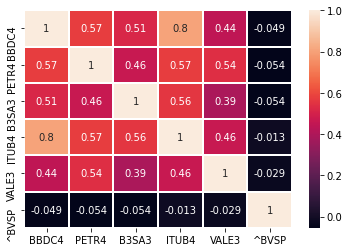

In [25]:
sns.heatmap(corr, linewidths=.1, annot=True)

### Separacao base de treino e teste

In [ ]:
#numero de dias a serem utilizados como parametro
Ntest = 1000
train = retornos.iloc[1:-Ntest]
test = retornos.iloc[-Ntest: -1]

#define coluna apenas com as features
x_cols = retornos.columns.drop('^BVSP')

#base treino
Xtrain = train[x_cols]
Ytrain = train['^BVSP']

#base teste
Xtest = test[x_cols]
Ytest = test['^BVSP']

### LINEAR REGRESSION

0.512396694214876 0.5205205205205206
Retorno treino Algoritimo: 1.13626749240385
Retorno teste Algoritimo: 0.5183456546699692

Retorno treino B&H: 0.6886836230182443
Retorno teste B&H: 0.467677201364068

vol_algo 0.4520964093231241
vol_bvsp 0.5646970520768495

sharpe_algo 1.1465378710838094
sharpe_bvsp 0.8281913277996392


c:\Users\maike\anaconda3\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


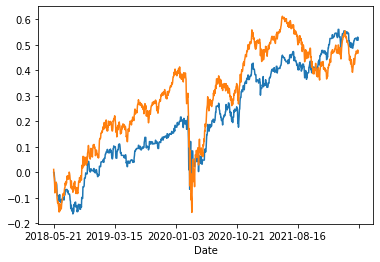

In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(Xtrain, Ytrain)
model.score(Xtrain, Ytrain), model.score(Xtest, Ytest)

# Direcao
import numpy as np
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
print(np.mean(np.sign(Ptrain)==np.sign(Ytrain)), np.mean(np.sign(Ptest)==np.sign(Ytest)))

retornos['POSICAO'] = 0
retornos.loc[1:-Ntest, 'POSICAO'] = (Ptrain > 0)
retornos.loc[-Ntest:-1, 'POSICAO'] = (Ptest > 0)

retornos['AlgoRetorno'] = retornos['POSICAO']*retornos['^BVSP']

print('Retorno treino Algoritimo:',retornos.iloc[1:-Ntest]['AlgoRetorno'].sum())
print('Retorno teste Algoritimo:',retornos.iloc[-Ntest:-1]['AlgoRetorno'].sum())
print('\nRetorno treino B&H:', Ytrain.sum())
print('Retorno teste B&H:', Ytest.sum())

df = retornos.iloc[-Ntest:-1]
df['AlgoRetorno'].cumsum().plot()
df['^BVSP'].cumsum().plot()

print('\nvol_algo', df['AlgoRetorno'].std()*np.sqrt(len(df)))
print('vol_bvsp', df['^BVSP'].std()*np.sqrt(len(df)))
print('\nsharpe_algo', retornos.iloc[-Ntest:-1]['AlgoRetorno'].sum()/(df['AlgoRetorno'].std()*np.sqrt(len(df))))
print('sharpe_bvsp', retornos.iloc[-Ntest:-1]['^BVSP'].sum()/(df['^BVSP'].std()*np.sqrt(len(df))))

### LOGISTIC REGRESSION

Retorno treino Algoritimo: 0.8108033001765942
Retorno teste Algoritimo: 0.7850235684498017

Retorno treino B&H: 0.6886836230182443
Retorno teste B&H: 0.467677201364068

vol_algo 0.4841635842907023
vol_bvsp 0.5646970520768495

sharpe_algo 1.6214015137050386
sharpe_bvsp 0.8281913277996392


c:\Users\maike\anaconda3\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


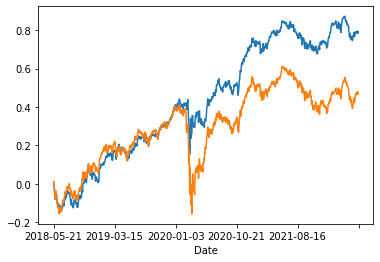

In [11]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=10)
Ctrain = (Ytrain > 0)
Ctest = (Ytest > 0)
model.fit(Xtrain, Ctrain)
model.score(Xtrain, Ctrain), model.score(Xtest, Ctest)

Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

retornos.loc[1:-Ntest, 'POSICAO'] = Ptrain
retornos.loc[-Ntest:-1, 'POSICAO'] = Ptest
retornos['AlgoRetorno'] = retornos['POSICAO']*retornos['^BVSP']

print('Retorno treino Algoritimo:',retornos.iloc[1:-Ntest]['AlgoRetorno'].sum())
print('Retorno teste Algoritimo:',retornos.iloc[-Ntest:-1]['AlgoRetorno'].sum())
print('\nRetorno treino B&H:', Ytrain.sum())
print('Retorno teste B&H:', Ytest.sum())

df = retornos.iloc[-Ntest:-1]
df['AlgoRetorno'].cumsum().plot()
df['^BVSP'].cumsum().plot()

print('\nvol_algo', df['AlgoRetorno'].std()*np.sqrt(len(df)))
print('vol_bvsp', df['^BVSP'].std()*np.sqrt(len(df)))
print('\nsharpe_algo', retornos.iloc[-Ntest:-1]['AlgoRetorno'].sum()/(df['AlgoRetorno'].std()*np.sqrt(len(df))))
print('sharpe_bvsp', retornos.iloc[-Ntest:-1]['^BVSP'].sum()/(df['^BVSP'].std()*np.sqrt(len(df))))

### RANDOM FOREST

Retorno treino Algoritimo: 16.44579321480443
Retorno teste Algoritimo: 0.3395276093482822

Retorno treino B&H: 0.643053673951833
Retorno teste B&H: 0.467677201364068

vol_algo 0.43261055613847854
vol_bvsp 0.5646970520768495

sharpe_algo 0.7848343146753901
sharpe_bvsp 0.8281913277996392


c:\Users\maike\anaconda3\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


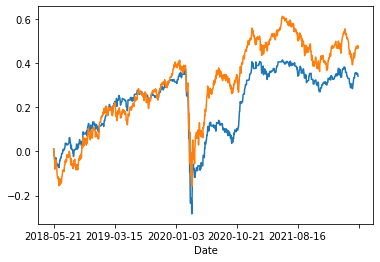

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=3)
Ctrain = (Ytrain > 0)
Ctest = (Ytest > 0)
model.fit(Xtrain, Ctrain)
model.score(Xtrain, Ctrain), model.score(Xtest, Ctest)

Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

retornos.loc[1:-Ntest, 'POSICAO'] = Ptrain
retornos.loc[-Ntest:-1, 'POSICAO'] = Ptest
retornos['AlgoRetorno'] = retornos['POSICAO']*retornos['^BVSP']

print('Retorno treino Algoritimo:',retornos.iloc[1:-Ntest]['AlgoRetorno'].sum())
print('Retorno teste Algoritimo:',retornos.iloc[-Ntest:-1]['AlgoRetorno'].sum())
print('\nRetorno treino B&H:', Ytrain.sum())
print('Retorno teste B&H:', Ytest.sum())

df = retornos.iloc[-Ntest:-1]
df['AlgoRetorno'].cumsum().plot()
df['^BVSP'].cumsum().plot()

print('\nvol_algo', df['AlgoRetorno'].std()*np.sqrt(len(df)))
print('vol_bvsp', df['^BVSP'].std()*np.sqrt(len(df)))
print('\nsharpe_algo', retornos.iloc[-Ntest:-1]['AlgoRetorno'].sum()/(df['AlgoRetorno'].std()*np.sqrt(len(df))))
print('sharpe_bvsp', retornos.iloc[-Ntest:-1]['^BVSP'].sum()/(df['^BVSP'].std()*np.sqrt(len(df))))